
# The 2nd place solution of the [RetailHero Uplift Modelling contest ](https://retailhero.ai/c/uplift_modeling/overview)  

### To open Notebook for read, use [nbviewer](https://nbviewer.jupyter.org/github/kirrlix1994/Retail_hero/blob/master/Retail_hero_contest_2nd_place_solution.ipynb)

## Summary of the solution:
###### Main points to get good results in this competition:
-	Use few features, pre-select features. My best submission used only 6 ones!


-	Make NOT very complex estimators for fitting. I used mainly different gradient boosting realizations (Catboost / Xgboost / Lightgbm), best results gave models with trees of death 1-2.


-	Use Class transformation approach for uplift modelling.


- Try to make more accurate local validation and do not rely only on public validation score. For testing hypotheses I used to make N (N = 30, 50) train - test splits and calculate test scores mean and standard deviation for making decisions.

### Additional info:
  
  Package with different uplift model realizations:  
 [uplift modelling package](https://github.com/maks-sh/scikit-uplift/)

  Tutorial about uplift and approaches (in Russian):  
 [uplift modeling approaches article](https://habr.com/ru/company/ru_mts/blog/485980/)
    
  Additional code with my feature engenearing, experimemts and validation:  
 [retail hero research](/research)


##### code is on py37, requirements:
- numpy==1.16.1
- pandas==0.24.1
- scikit-learn==0.21.3
- scikit-uplift==0.0.3
- xgboost==0.90
- matplotlib==3.1.1

In [243]:
!pip install scikit-uplift
!pip install xgboost

In [1]:
import gc
import pandas as pd
import numpy as np
from datetime import datetime

from xgboost import XGBClassifier
from sklift.models import ClassTransformation

from sklift.metrics import uplift_at_k
import matplotlib.pyplot as plt
import catboost as cb
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import optuna
import pandas as pd
from pandas import read_csv

%matplotlib inline

In [2]:
data = read_csv('dataset.csv')

#### SET  MODEL
Use uplift class tranformation approach for uplift prediction with XGBoost as an estimator.

In [3]:
xgb_est_params = {
    'max_depth':4,
    'learning_rate': 0.17, 
    'n_estimators': 195,
    'nthread':40,
    'n_gpus':0,
    'seed':42
}

estimator = XGBClassifier(
    **xgb_est_params
)

uplift_model_cl_tr = ClassTransformation(
    estimator=estimator
)

-----

#### FIT MODEL ON ALL TRAIN DATA

In [4]:
y = data['response_att']
X = data.copy()

features_list = ['group', 'response_att',
 'perdelta_days_between_visits_15_30d',
 'k_var_days_between_visits_1m',
 'k_var_days_between_visits_3m',
 'k_var_days_between_visits_15d',
 'cheque_count_6m_g48',
 'response_sms',
 'cheque_count_6m_g40',
 'k_var_count_per_cheque_6m_g27',
 'k_var_disc_share_6m_g27',
 'response_viber',
 'k_var_discount_depth_1m',
 'k_var_sku_price_6m_g48',
 'cheque_count_6m_g25',
 'cheque_count_12m_g41',
 'cheque_count_6m_g41',
 'cheque_count_12m_g32',
 'sale_count_12m_g54',
 'cheque_count_6m_g32',
 'k_var_sku_price_6m_g26',
 'k_var_disc_share_6m_g24',
 'food_share_1m',
 'k_var_cheque_3m',
 'age',
 'stdev_days_between_visits_15d',
 'cheque_count_6m_g38',
 'cheque_count_3m_g57',
 'cheque_count_12m_g25',
 'months_from_register',
 'main_format',
 'food_share_15d',
 'cheque_count_12m_g48',
 'k_var_disc_share_15d_g24',
 'sale_count_12m_g49',
 'cheque_count_6m_g21',
 'crazy_purchases_goods_count_12m',
 'cheque_count_3m_g25',
 'sale_count_3m_g57',
 'k_var_sku_price_3m_g49',
 'k_var_sku_price_15d_g49',
 'k_var_disc_share_1m_g40',
 'k_var_disc_share_3m_g24',
 'k_var_sku_price_6m_g49',
 'cheque_count_6m_g42'
 'k_var_cheque_15d'
]

# features_list = features_list[:17]

#X = X.filter(features_list)
pd.set_option('display.max_columns', 500)
X.head(5)

,Unnamed: 0,CardHolder,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,cheque_count_12m_g42,cheque_count_12m_g45,cheque_count_12m_g46,cheque_count_12m_g48,cheque_count_12m_g52,cheque_count_12m_g56,cheque_count_12m_g57,cheque_count_12m_g58,cheque_count_12m_g79,cheque_count_3m_g20,cheque_count_3m_g21,cheque_count_3m_g25,cheque_count_3m_g42,cheque_count_3m_g45,cheque_count_3m_g52,cheque_count_3m_g56,cheque_count_3m_g57,cheque_count_3m_g79,cheque_count_6m_g20,cheque_count_6m_g21,cheque_count_6m_g25,cheque_count_6m_g32,cheque_count_6m_g33,cheque_count_6m_g38,cheque_count_6m_g39,cheque_count_6m_g40,cheque_count_6m_g41,cheque_count_6m_g42,cheque_count_6m_g45,cheque_count_6m_g46,cheque_count_6m_g48,cheque_count_6m_g52,cheque_count_6m_g56,cheque_count_6m_g57,cheque_count_6m_g58,cheque_count_6m_g79,children,crazy_purchases_cheque_count_12m,crazy_purchases_cheque_count_1m,crazy_purchases_cheque_count_3m,crazy_purchases_cheque_count_6m,crazy_purchases_goods_count_12m,crazy_purchases_goods_count_6m,disc_sum_6m_g34,food_share_15d,food_share_1m,gender,group,k_var_cheque_15d,k_var_cheque_3m,k_var_cheque_category_width_15d,k_var_cheque_group_width_15d,k_var_count_per_cheque_15d_g24,k_var_count_per_cheque_15d_g34,k_var_count_per_cheque_1m_g24,k_var_count_per_cheque_1m_g27,k_var_count_per_cheque_1m_g34,k_var_count_per_cheque_1m_g44,k_var_count_per_cheque_1m_g49,k_var_count_per_cheque_3m_g24,k_var_count_per_cheque_3m_g27,k_var_count_per_cheque_3m_g32,k_var_count_per_cheque_3m_g34,k_var_count_per_cheque_3m_g41,k_var_count_per_cheque_3m_g44,k_var_count_per_cheque_6m_g24,k_var_count_per_cheque_6m_g27,k_var_count_per_cheque_6m_g32,k_var_count_per_cheque_6m_g44,k_var_days_between_visits_15d,k_var_days_between_visits_1m,k_var_days_between_visits_3m,k_var_disc_per_cheque_15d,k_var_disc_share_12m_g32,k_var_disc_share_15d_g24,k_var_disc_share_15d_g34,k_var_disc_share_15d_g49,k_var_disc_share_1m_g24,k_var_disc_share_1m_g27,k_var_disc_share_1m_g34,k_var_disc_share_1m_g40,k_var_disc_share_1m_g44,k_var_disc_share_1m_g49,k_var_disc_share_1m_g54,k_var_disc_share_3m_g24,k_var_disc_share_3m_g26,k_var_disc_share_3m_g27,k_var_disc_share_3m_g32,k_var_disc_share_3m_g33,k_var_disc_share_3m_g34,k_var_disc_share_3m_g38,k_var_disc_share_3m_g40,k_var_disc_share_3m_g41,k_var_disc_share_3m_g44,k_var_disc_share_3m_g46,k_var_disc_share_3m_g48,k_var_disc_share_3m_g49,k_var_disc_share_3m_g54,k_var_disc_share_6m_g24,k_var_disc_share_6m_g27,k_var_disc_share_6m_g32,k_var_disc_share_6m_g34,k_var_disc_share_6m_g44,k_var_disc_share_6m_g46,k_var_disc_share_6m_g49,k_var_disc_share_6m_g54,k_var_discount_depth_15d,k_var_discount_depth_1m,k_var_sku_per_cheque_15d,k_var_sku_price_12m_g32,k_var_sku_price_15d_g34,k_var_sku_price_15d_g49,k_var_sku_price_1m_g24,k_var_sku_price_1m_g26,k_var_sku_price_1m_g27,k_var_sku_price_1m_g34,k_var_sku_price_1m_g40,k_var_sku_price_1m_g44,k_var_sku_price_1m_g49,k_var_sku_price_1m_g54,k_var_sku_price_3m_g24,k_var_sku_price_3m_g26,k_var_sku_price_3m_g27,k_var_sku_price_3m_g32,k_var_sku_price_3m_g33,k_var_sku_price_3m_g34,k_var_sku_price_3m_g40,k_var_sku_price_3m_g41,k_var_sku_price_3m_g44,k_var_sku_price_3m_g46,k_var_sku_price_3m_g48,k_var_sku_price_3m_g49,k_var_sku_price_3m_g54,k_var_sku_price_6m_g24,k_var_sku_price_6m_g26,k_var_sku_price_6m_g27,k_var_sku_price_6m_g32,k_var_sku_price_6m_g41,k_var_sku_price_6m_g42,k_var_sku_price_6m_g44,k_var_sku_price_6m_g48,k_var_sku_price_6m_g49,main_format,mean_discount_depth_15d,months_from_register,perdelta_days_between_visits_15_30d,promo_share_15d,response_att,response_sms,response_viber,sale_count_12m_g32,sale_count_12m_g33,sale_count_12m_g49,sale_count_12m_g54,sale_count_12m_g57,sale_count_3m_g24,sale_count_3m_g33,sale_count_3m_g57,sale_count_6m_g24,sale_count_6m_g25,sale_count_6m_g32,sale_count_6m_g33,sale_count_6m_g44,sale_count_6m_g54,sale_count_6m_g57,sale_sum_12m_g24,sale_sum_12m_g25,sale_s

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [5]:
X_train = X

In [6]:
uplift_model_cl_tr.fit(
    X=X_train.drop(columns=['group', 'response_att']),
    y=X_train['response_att'],
    treatment=X_train['group']
)

/anaconda/envs/azureml_py36_automl/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.



ClassTransformation(estimator=XGBClassifier(learning_rate=0.17, max_depth=4,
                                            n_estimators=195, n_gpus=0,
                                            nthread=40, seed=42))

--------

#### Make predictions on whole train and test sets.

#### Calculate uplift@30% metric on train data.

###### **NOTE: In this contest uplift@30% metric calculates as follows: 
All test data are sorted in descending order by 'predicted uplift'. Then calculates target share / conversion in top 30% of treatment group and conversion in top 30% of control group SEPARATELY. Metric is then the difference between two conversions.
<br>

 Usually uplift@30% metric calculates differently. Firstly selects top 30% of ALL test data and only then calculates conversion  in treatment and control group and they are subtracted.

In [8]:
# predicts
uplift_tr = uplift_model_cl_tr.predict(
    X_train.drop(columns=['group', 'response_att']),
)

uplift_ts = uplift_model_cl_tr.predict(
    X_test.drop(columns=['group', 'response_att'])
)

In [9]:
# score on train:
df_train_scores = X_train[['group', 'response_att']].assign(uplift_score=uplift_tr)
    
train_score = uplift_at_k(
    y_true=df_train_scores['response_att'],
    uplift=df_train_scores['uplift_score'],
    treatment=df_train_scores['group'],
    strategy='by_group'  # by_group overall
)

print(f'Uplift@30% on train data: {train_score:.3f}')

Uplift@30% on train data: 0.048


#### Make submit:

In [10]:
df_submit = X_test.assign(uplift=uplift_ts)[['uplift']]

print(f'Submit data shape: {df_submit.shape}\n')
df_submit.head(2)

#df_submit.to_csv('submissions/retail_hero_2nd_place_submit.csv')

#!head -5 submissions/retail_hero_2nd_place_submit.csv

Submit data shape: (206109, 1)



,uplift
385364,-0.088642
117440,-0.129026


-----

------

##### FEATURE IMPORTANCE

There is the area of research, how to calculate feature importance in uplift models.  

Here feature importance is just vanilla information gain in XGBoost estimator, used in Class transformation approach.


In [11]:
df_feat_imp = pd.DataFrame([
    uplift_model_cl_tr\
        .estimator\
        .get_booster()\
        .get_score(importance_type='gain')
        ]
).T.reset_index()

df_feat_imp.columns =\
    ["feature", "value"]
    
list(df_feat_imp\
    .sort_values('value', ascending=False)['feature'])

['response_viber',
 'k_var_days_between_visits_15d',
 'response_sms',
 'k_var_days_between_visits_1m',
 'months_from_register',
 'perdelta_days_between_visits_15_30d',
 'cheque_count_6m_g40',
 'k_var_days_between_visits_3m',
 'k_var_sku_price_6m_g49',
 'cheque_count_6m_g48',
 'stdev_days_between_visits_15d',
 'main_format',
 'cheque_count_12m_g41',
 'food_share_1m',
 'cheque_count_6m_g32',
 'cheque_count_12m_g48',
 'age',
 'food_share_15d',
 'sale_count_12m_g49',
 'cheque_count_6m_g41',
 'cheque_count_6m_g25',
 'k_var_discount_depth_1m',
 'cheque_count_12m_g25',
 'cheque_count_3m_g57',
 'cheque_count_12m_g32',
 'cheque_count_3m_g25',
 'cheque_count_6m_g38',
 'k_var_count_per_cheque_6m_g27',
 'k_var_cheque_3m',
 'k_var_disc_share_6m_g27',
 'k_var_sku_price_6m_g48',
 'k_var_sku_price_6m_g26',
 'k_var_disc_share_6m_g24',
 'k_var_disc_share_3m_g24',
 'sale_count_12m_g54',
 'k_var_sku_price_15d_g49',
 'k_var_disc_share_15d_g24',
 'k_var_sku_price_3m_g49',
 'sale_count_3m_g57',
 'cheque_coun

------

##### PLOT ULIFT PREDICTIONS FOR TRAIN / TEST DATA

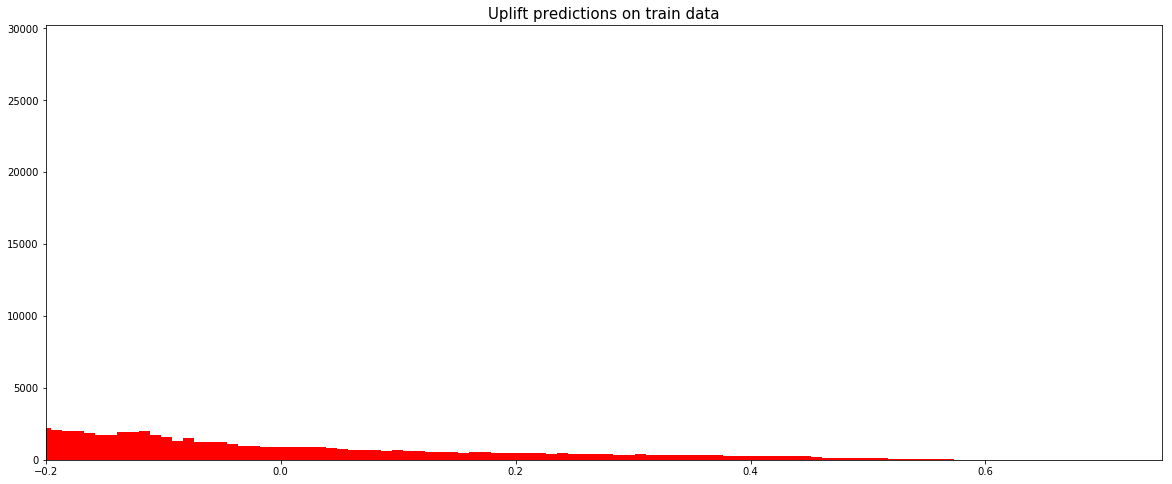

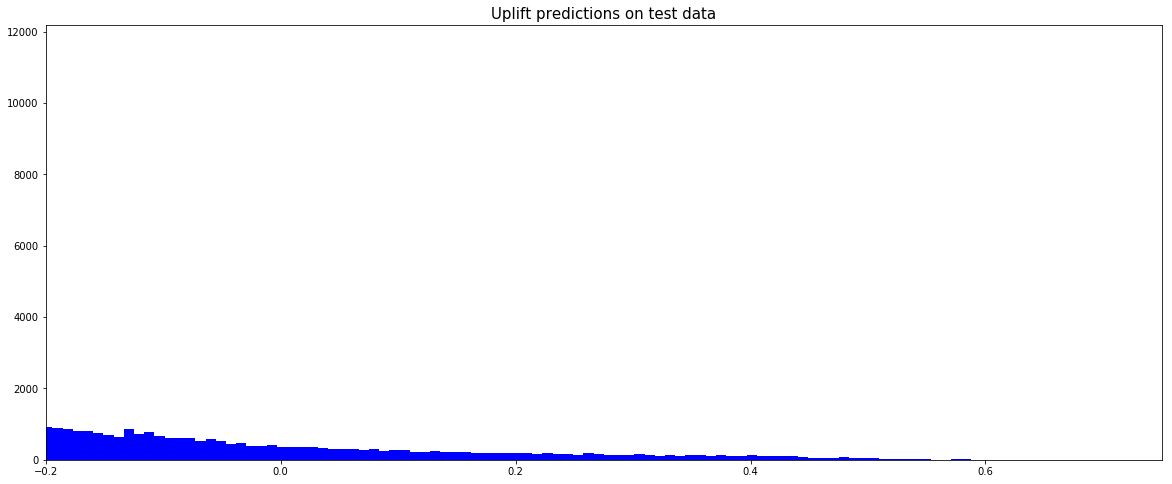

In [12]:
plt.figure(figsize=(20, 8));

plt.hist(
    df_train_scores['uplift_score'],
    bins=200, 
    color='red', 
);

plt.xlim(-0.2, 0.75);
plt.title('Uplift predictions on train data', size=15);


plt.figure(figsize=(20, 8));

plt.hist(
    df_submit['uplift'],
    bins=200, 
    color='blue', 
);

plt.xlim(-0.2, 0.75);
plt.title('Uplift predictions on test data', size=15);

In [13]:
def custom_metric(answers, take_top_ratio=0.25):
    answers.sort_values(by='uplift', inplace=True, ascending=False)
    
    n_samples = int(np.ceil(answers.shape[0] * take_top_ratio))
    answers = answers.iloc[:n_samples, :]
    answers_test = answers[answers['group'] == 1]['response_att'].sum() / \
                   answers[answers['group'] == 1].shape[0]
    answers_control = answers[answers['group'] == 0]['response_att'].sum() / \
                      answers[answers['group'] == 0].shape[0]
    return (answers_test - answers_control) * 100

In [14]:
df_submit['group'] = X_test['group']
df_submit['response_att'] = X_test['response_att']
print(custom_metric(df_submit))

6.443881743786328


100
200
300
400
500
600
700
800
900
1000


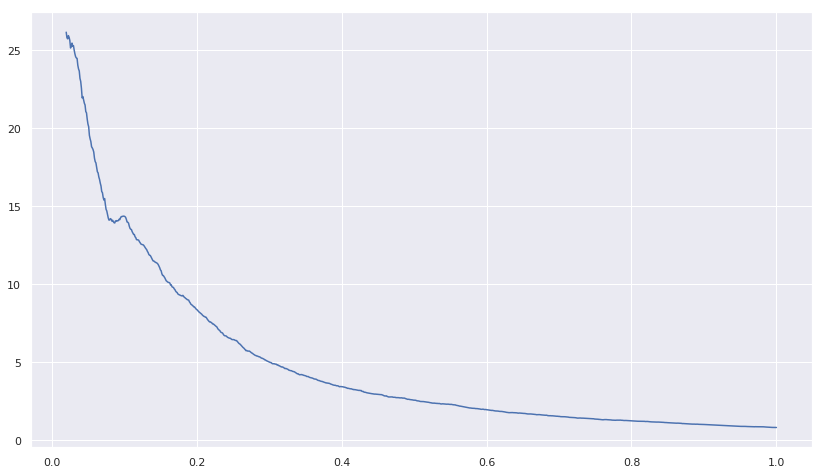

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")
x = []
answers = []
num = 1000
for i in range(20, num + 1):
    if i % 100 == 0:
        print(i)
    x.append(1.0 * i / num)
    answers.append(custom_metric(df_submit, take_top_ratio=1.0 * i/ num))
    
plt.figure(figsize=(14,8))
plt.plot(x, answers)
plt.minorticks_on()
plt.show()

In [237]:
features_list = [
 'perdelta_days_between_visits_15_30d',
 'k_var_days_between_visits_1m',
 'k_var_days_between_visits_3m',
 'k_var_days_between_visits_15d',
 'cheque_count_6m_g48',
 'response_sms',
 'cheque_count_6m_g40',
 'k_var_count_per_cheque_6m_g27',
 'k_var_disc_share_6m_g27',
 'response_viber',
 'k_var_discount_depth_1m',
 'k_var_sku_price_6m_g48',
 'cheque_count_6m_g25',
 'cheque_count_12m_g41',
 'cheque_count_6m_g41',
 'cheque_count_12m_g32',
 'sale_count_12m_g54',
 'cheque_count_6m_g32',
 'k_var_sku_price_6m_g26',
 'k_var_disc_share_6m_g24',
 'food_share_1m',
 'k_var_cheque_3m',
 'age',
 'stdev_days_between_visits_15d',
 'cheque_count_6m_g38',
 'cheque_count_3m_g57',
 'cheque_count_12m_g25',
 'months_from_register',
 'main_format',
 'food_share_15d',
 'cheque_count_12m_g48',
 'k_var_disc_share_15d_g24',
 'sale_count_12m_g49',
 'cheque_count_6m_g21',
 'crazy_purchases_goods_count_12m',
 'cheque_count_3m_g25',
 'sale_count_3m_g57',
 'k_var_sku_price_3m_g49',
 'k_var_sku_price_15d_g49',
 'k_var_disc_share_1m_g40',
 'k_var_disc_share_3m_g24',
 'k_var_sku_price_6m_g49',
 'cheque_count_6m_g42'
 'k_var_cheque_15d'
]

In [8]:
#features_list = features_list[2:]
data = read_csv('test.csv')
X = data.copy()
X_test = X# .drop(columns=['group', 'response_att'])#X.filter(features_list)
uplift_ts = uplift_model_cl_tr.predict(
    X_test
)
answer = X[['CardHolder']].assign(uplift=uplift_ts)
answer = answer.reset_index(drop=True)
answer.to_csv('answer14.csv', index=False, sep=';')